# Hostpial Data Visualization

In [9]:
# All libraries should be downloaded.
import pandas as pd
import matplotlib as plt
import psycopg
from credentials import DBNAME, USER, PASSWORD


In [10]:
# Getting Hospital Data
import pandas as pd
import psycopg
from credentials import DBNAME, USER, PASSWORD

conn = psycopg.connect(
    host="pinniped.postgres.database.azure.com",
    dbname=DBNAME, user=USER, password=PASSWORD
)

query_1 = "SELECT * FROM hospital;"
query_2 = "SELECT * FROM beds"
query_3 = "SELECT * FROM quality"

hospital_df = pd.read_sql(query_1, conn)
beds_df = pd.read_sql(query_2, conn)
quality_df = pd.read_sql(query_3, conn)

conn.close()

<ipython-input-10-04b7f9cc0468>:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  hospital_df = pd.read_sql(query_1, conn)
<ipython-input-10-04b7f9cc0468>:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  beds_df = pd.read_sql(query_2, conn)
<ipython-input-10-04b7f9cc0468>:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  quality_df = pd.read_sql(query_3, conn)


## Data Analysis

### Question 1

/var/folders/xz/c0khkz7n2430xgjrwftb3cr40000gn/T/ipykernel_68278/4248787594.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  beds_df = pd.read_sql(query_2, conn)


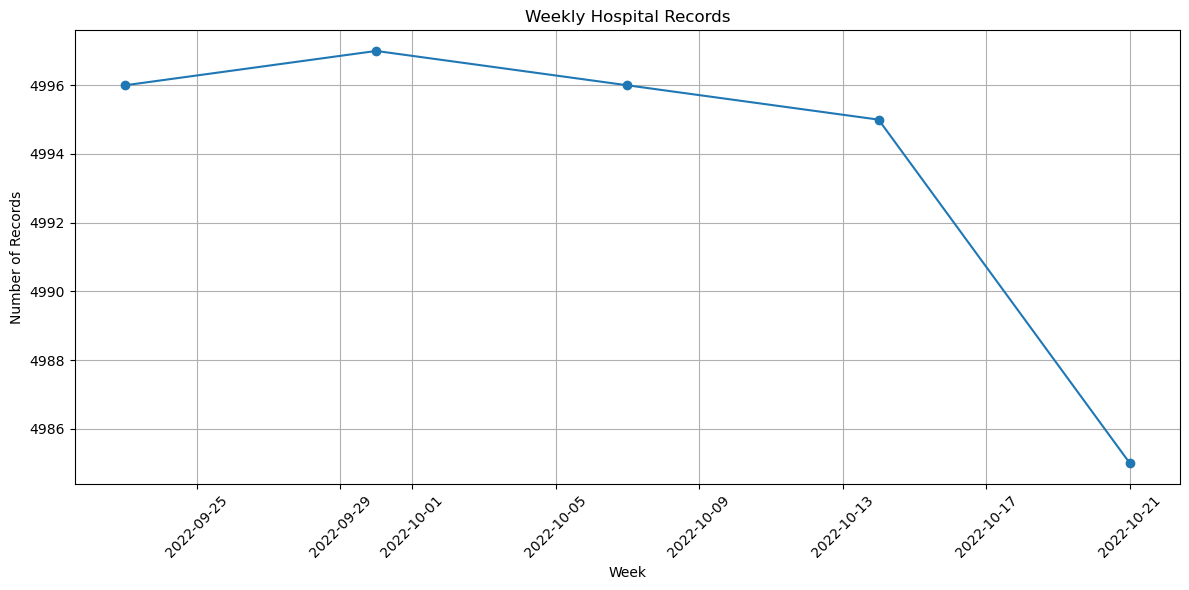

In [1]:
# A summary of how many hospital records were loaded in the week selected by the user, and how that compares to previous weeks.

import pandas as pd
import matplotlib.pyplot as plt
import psycopg
from credentials import DBNAME, USER, PASSWORD

conn = psycopg.connect(
    host="pinniped.postgres.database.azure.com",
    dbname=DBNAME, user=USER, password=PASSWORD
)

query_2 = "SELECT * FROM beds"

beds_df = pd.read_sql(query_2, conn)

conn.close()

beds_df['collection_week'] = pd.to_datetime(beds_df['collection_week'])
weekly_counts = beds_df.groupby('collection_week').size().reset_index(name='record_count')
weekly_counts.sort_values('collection_week', inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(weekly_counts['collection_week'], weekly_counts['record_count'], marker='o')
plt.xlabel('Week')
plt.ylabel('Number of Records')
plt.title('Weekly Hospital Records')
plt.xticks(rotation=45)  
plt.grid(True)
plt.tight_layout()  
plt.show()

### Question 2

In [2]:
# A table summarizing the number of adult and pediatric beds available that week, the number used, and the number used by patients with COVID, compared to the 4 most recent weeks.

import pandas as pd
import matplotlib.pyplot as plt
import psycopg
from credentials import DBNAME, USER, PASSWORD

conn = psycopg.connect(
    host="pinniped.postgres.database.azure.com",
    dbname=DBNAME, user=USER, password=PASSWORD
)

query_2 = "SELECT * FROM beds"

beds_df = pd.read_sql(query_2, conn)

conn.close()

weekly_summary = beds_df.groupby('collection_week').agg({
    'all_adult_hospital_beds_7_day_avg': 'sum',
    'all_pediatric_inpatient_beds_7_day_avg': 'sum',
    'all_adult_hospital_inpatient_bed_occupied_7_day_coverage': 'sum',
    'all_pediatric_inpatient_bed_occupied_7_day_avg': 'sum',
    'inpatient_beds_used_covid_7_day_avg': 'sum'
}).reset_index()

weekly_summary.sort_values('collection_week', ascending=False, inplace=True)
comparison_weeks = weekly_summary.head(5)
comparison_weeks

/var/folders/xz/c0khkz7n2430xgjrwftb3cr40000gn/T/ipykernel_68278/2269342400.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  beds_df = pd.read_sql(query_2, conn)


,collection_week,all_adult_hospital_beds_7_day_avg,all_pediatric_inpatient_beds_7_day_avg,all_adult_hospital_inpatient_bed_occupied_7_day_coverage,all_pediatric_inpatient_bed_occupied_7_day_avg,inpatient_beds_used_covid_7_day_avg
4,2022-10-21,-11585107.7,-443959673.8,34376.0,-627969665.5,-1.919974e+09
3,2022-10-14,-7587053.0,-422959865.4,34841.0,-617970583.0,-1.940974e+09
2,2022-10-07,-7584526.6,-422959780.2,34886.0,-624971089.2,-1.895974e+09
1,2022-09-30,-12583707.6,-429959765.3,34852.0,-616971340.2,-1.948974e+09
0,2022-09-23,-10586399.5,-430959964.5,34832.0,-634971586.9,-1.914972e+09


### Question 3

In [1]:
# A graph or table summarizing the fraction of beds in use by hospital quality rating, so we can compare high-quality and low-quality hospitals.

import pandas as pd
import matplotlib.pyplot as plt
import psycopg
from credentials import DBNAME, USER, PASSWORD

conn = psycopg.connect(
    host="pinniped.postgres.database.azure.com",
    dbname=DBNAME, user=USER, password=PASSWORD
)

query_2 = "SELECT * FROM beds"
query_3 = "SELECT * FROM quality"

beds_df = pd.read_sql(query_2, conn)
quality_df = pd.read_sql(query_3, conn)

conn.close()

merged_df = pd.merge(beds_df, quality_df, left_on='hospital_pk', right_on='facility_id')

merged_df['total_beds'] = merged_df['all_adult_hospital_beds_7_day_avg'] + merged_df['all_pediatric_inpatient_beds_7_day_avg']
merged_df['beds_in_use'] = merged_df['all_adult_hospital_inpatient_bed_occupied_7_day_coverage'] + merged_df['all_pediatric_inpatient_bed_occupied_7_day_avg']

merged_df['fraction_beds_in_use'] = merged_df['beds_in_use'] / merged_df['total_beds']

quality_bed_usage = merged_df.groupby('quality_rating')['fraction_beds_in_use'].mean().reset_index()

quality_bed_usage

<ipython-input-1-9c73341f58e6>:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  beds_df = pd.read_sql(query_2, conn)
<ipython-input-1-9c73341f58e6>:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  quality_df = pd.read_sql(query_3, conn)


,quality_rating,fraction_beds_in_use


### Question 4

/var/folders/xz/c0khkz7n2430xgjrwftb3cr40000gn/T/ipykernel_68278/3499266868.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  beds_df = pd.read_sql(query_2, conn)


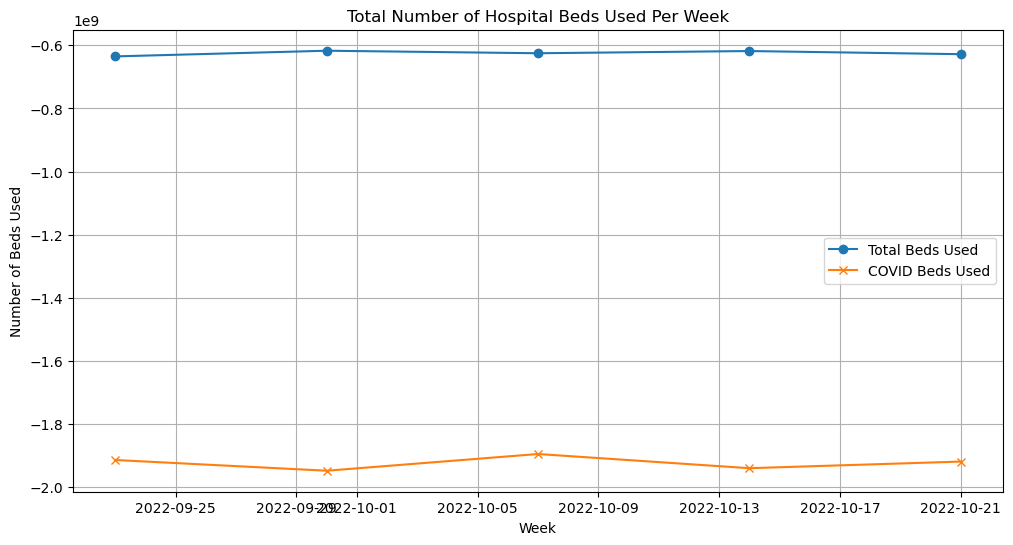

In [4]:
# A plot of the total number of hospital beds used per week, over all time up to the selected week, split into all cases and COVID cases.

import pandas as pd
import matplotlib.pyplot as plt
import psycopg
from credentials import DBNAME, USER, PASSWORD

conn = psycopg.connect(
    host="pinniped.postgres.database.azure.com",
    dbname=DBNAME, user=USER, password=PASSWORD
)

query_2 = "SELECT * FROM beds"

beds_df = pd.read_sql(query_2, conn)

conn.close()

beds_df['collection_week'] = pd.to_datetime(beds_df['collection_week'])

weekly_beds_usage = beds_df.groupby('collection_week').agg({
    'all_adult_hospital_inpatient_bed_occupied_7_day_coverage': 'sum',
    'all_pediatric_inpatient_bed_occupied_7_day_avg': 'sum',
    'inpatient_beds_used_covid_7_day_avg': 'sum'
}).reset_index()

weekly_beds_usage['total_beds_used'] = (weekly_beds_usage['all_adult_hospital_inpatient_bed_occupied_7_day_coverage'] +
                                        weekly_beds_usage['all_pediatric_inpatient_bed_occupied_7_day_avg'])

plt.figure(figsize=(12, 6))
plt.plot(weekly_beds_usage['collection_week'], weekly_beds_usage['total_beds_used'], label='Total Beds Used', marker='o')
plt.plot(weekly_beds_usage['collection_week'], weekly_beds_usage['inpatient_beds_used_covid_7_day_avg'], label='COVID Beds Used', marker='x')
plt.xlabel('Week')
plt.ylabel('Number of Beds Used')
plt.title('Total Number of Hospital Beds Used Per Week')
plt.legend()
plt.grid(True)
plt.show()

### Question 5

<ipython-input-4-877988fbaed4>:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  hospital_df = pd.read_sql(query_1, conn)
<ipython-input-4-877988fbaed4>:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  beds_df = pd.read_sql(query_2, conn)


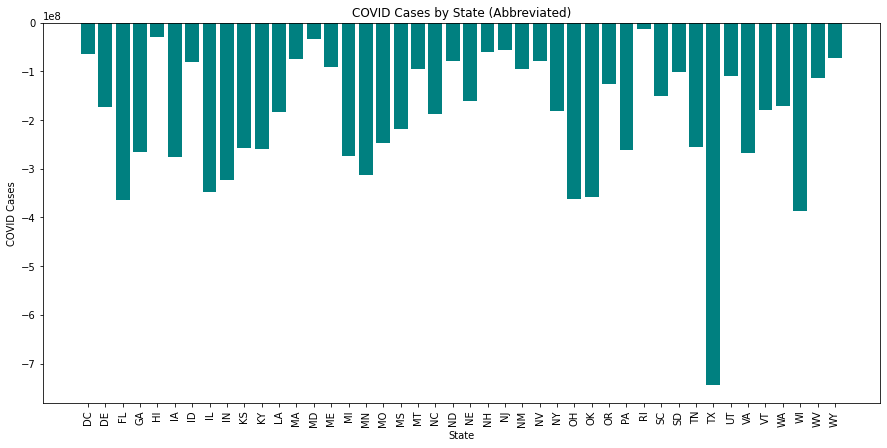

In [4]:
# A map showing the number of COVID cases by state (the first two digits of a hospital FIPS code is its state)

import pandas as pd
import matplotlib.pyplot as plt
import psycopg
from credentials import DBNAME, USER, PASSWORD

conn = psycopg.connect(
    host="pinniped.postgres.database.azure.com",
    dbname=DBNAME, user=USER, password=PASSWORD
)

query_1 = "SELECT * FROM hospital"
query_2 = "SELECT * FROM beds"

hospital_df = pd.read_sql(query_1, conn)
beds_df = pd.read_sql(query_2, conn)

conn.close()

state_code_to_abbrev = {
    '01': 'AL', '02': 'AK', '04': 'AZ', '05': 'AR',
    '06': 'CA', '08': 'CO', '09': 'CT', '10': 'DE',
    '11': 'DC', '12': 'FL', '13': 'GA', '15': 'HI',
    '16': 'ID', '17': 'IL', '18': 'IN', '19': 'IA',
    '20': 'KS', '21': 'KY', '22': 'LA', '23': 'ME',
    '24': 'MD', '25': 'MA', '26': 'MI', '27': 'MN',
    '28': 'MS', '29': 'MO', '30': 'MT', '31': 'NE',
    '32': 'NV', '33': 'NH', '34': 'NJ', '35': 'NM',
    '36': 'NY', '37': 'NC', '38': 'ND', '39': 'OH',
    '40': 'OK', '41': 'OR', '42': 'PA', '44': 'RI',
    '45': 'SC', '46': 'SD', '47': 'TN', '48': 'TX',
    '49': 'UT', '50': 'VT', '51': 'VA', '53': 'WA',
    '54': 'WV', '55': 'WI', '56': 'WY'
}

hospital_df['state_code'] = hospital_df['fips_code'].str[:2]

merged_data = pd.merge(beds_df, hospital_df[['hospital_pk', 'state_code']], on='hospital_pk')

merged_data['state_abbrev'] = merged_data['state_code'].map(state_code_to_abbrev)

statewise_covid_cases = merged_data.groupby('state_abbrev')['inpatient_beds_used_covid_7_day_avg'].sum().reset_index()

plt.figure(figsize=(15, 7))
plt.bar(statewise_covid_cases['state_abbrev'], statewise_covid_cases['inpatient_beds_used_covid_7_day_avg'], color='teal')
plt.xlabel('State')
plt.ylabel('COVID Cases')
plt.title('COVID Cases by State (Abbreviated)')
plt.xticks(rotation=90) 
plt.show()


### Question 6

In [3]:
# A table of the states in which the number of cases has increased by the most since last week

import pandas as pd
import matplotlib.pyplot as plt
import psycopg
from credentials import DBNAME, USER, PASSWORD

conn = psycopg.connect(
    host="pinniped.postgres.database.azure.com",
    dbname=DBNAME, user=USER, password=PASSWORD
)

query_1 = "SELECT * FROM hospital"
query_2 = "SELECT * FROM beds"

hospital_df = pd.read_sql(query_1, conn)
beds_df = pd.read_sql(query_2, conn)

conn.close()

# Convert 'collection_week' to datetime for proper sorting
beds_df['collection_week'] = pd.to_datetime(beds_df['collection_week'])

# Find the last two weeks in the dataset
last_two_weeks = beds_df['collection_week'].nlargest(2).sort_values()

# Filter data for these two weeks
recent_data = beds_df[beds_df['collection_week'].isin(last_two_weeks)]

# Merge with hospital data to get state information
merged_data = pd.merge(recent_data, hospital_df[['hospital_pk', 'state']], on='hospital_pk')

# Group by state and week, then sum COVID cases
grouped_data = merged_data.groupby(['state', 'collection_week'])['inpatient_beds_used_covid_7_day_avg'].sum().reset_index()

# Pivot the data to have weeks as columns
pivot_data = grouped_data.pivot(index='state', columns='collection_week', values='inpatient_beds_used_covid_7_day_avg')

# Calculate the difference in cases between the two weeks
pivot_data['case_increase'] = pivot_data[last_two_weeks.iloc[1]] - pivot_data[last_two_weeks.iloc[0]]

# Sort by the increase in cases
pivot_data = pivot_data.sort_values('case_increase', ascending=False)

# Selecting the relevant columns for the final table
final_table = pivot_data[['case_increase']].reset_index()

final_table.head()


<ipython-input-3-3fdb145eef55>:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  hospital_df = pd.read_sql(query_1, conn)
<ipython-input-3-3fdb145eef55>:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  beds_df = pd.read_sql(query_2, conn)


collection_week,state,case_increase
0,AK,0.0
1,PR,0.0
2,ND,0.0
3,NE,0.0
4,NH,0.0


### Question 7

In [7]:
# A table of the hospitals (including names and locations) with the largest changes in COVID cases in the last week

import pandas as pd
import matplotlib.pyplot as plt
import psycopg
from credentials import DBNAME, USER, PASSWORD

conn = psycopg.connect(
    host="pinniped.postgres.database.azure.com",
    dbname=DBNAME, user=USER, password=PASSWORD
)

query_1 = "SELECT * FROM hospital"
query_2 = "SELECT * FROM beds"

hospital_df = pd.read_sql(query_1, conn)
beds_df = pd.read_sql(query_2, conn)

conn.close()

beds_df['collection_week'] = pd.to_datetime(beds_df['collection_week'])

last_two_weeks = beds_df['collection_week'].nlargest(2).sort_values()

recent_data = beds_df[beds_df['collection_week'].isin(last_two_weeks)]

grouped_data = recent_data.groupby(['hospital_pk', 'collection_week'])['inpatient_beds_used_covid_7_day_avg'].sum().reset_index()

pivot_data = grouped_data.pivot(index='hospital_pk', columns='collection_week', values='inpatient_beds_used_covid_7_day_avg')

pivot_data['case_change'] = pivot_data[last_two_weeks.iloc[1]] - pivot_data[last_two_weeks.iloc[0]]

pivot_data = pivot_data.sort_values('case_change', ascending=False).reset_index()

final_table = pd.merge(pivot_data, hospital_df[['hospital_pk', 'hospital_name', 'address', 'city', 'state', 'zip']], on='hospital_pk')

final_table = final_table[['hospital_name', 'address', 'city', 'state', 'zip', 'case_change']]

final_table.head()  


/var/folders/xz/c0khkz7n2430xgjrwftb3cr40000gn/T/ipykernel_68278/2759473739.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  hospital_df = pd.read_sql(query_1, conn)
/var/folders/xz/c0khkz7n2430xgjrwftb3cr40000gn/T/ipykernel_68278/2759473739.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  beds_df = pd.read_sql(query_2, conn)


,hospital_name,address,city,state,zip,case_change
0,SOUTHEAST HEALTH MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,0.0
1,MARYMOUNT HOSPITAL,12300 MCCRACKEN ROAD,GARFIELD HEIGHTS,OH,44125,0.0
2,SOUTHWEST GENERAL HEALTH CENTER,18697 BAGLEY ROAD,MIDDLEBURG HEIGHTS,OH,44130,0.0
3,DOCTORS HOSPITAL,5100 WEST BROAD STREET,COLUMBUS,OH,43228,0.0
4,SUMMA WESTERN RESERVE HOSPITAL,1900 23RD STREET,CUYAHOGA FALLS,OH,44223,0.0
